# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization,LSTM,Bidirectional,GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm

from tensorflow.keras.metrics import RootMeanSquaredError,MeanSquaredError
import sklearn.preprocessing


# EDA

In [3]:
df=pd.read_csv("/content/AirPassengers.csv")
month=df["Month"]


In [4]:
#rename and set index like dates
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)
df.tail(10)

,Passengers
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


In [ ]:
#another way  to turn 1 column to index
series = pd.read_csv("/kaggle/input/air-passengers/AirPassengers.csv", header=0, index_col=0)
series

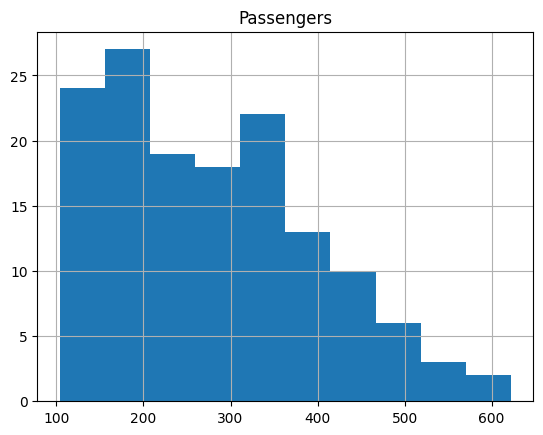

In [6]:
# data has non - normal distribution, which means can use only MinMaxScaler

df.hist()

# Save the plot
plt.savefig('histogram.png')

# Show the plot (optional)
plt.show()


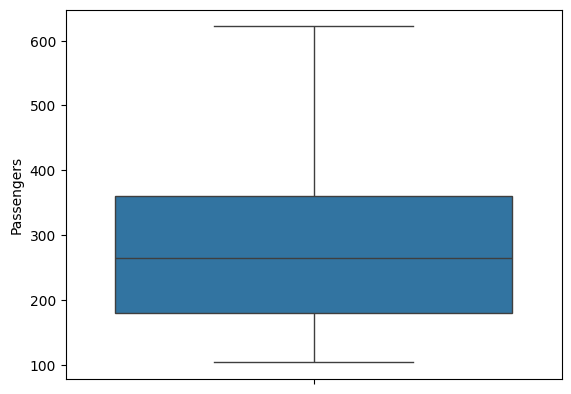

In [8]:
#outliers check
#data has no outliers
sns.boxplot(df.Passengers)
plt.savefig('boxplot.png')
plt.show()

In [9]:
#data has no missing values
print(df.describe())
print("NAN values:",df.isna().sum())

       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000
NAN values: Passengers    0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

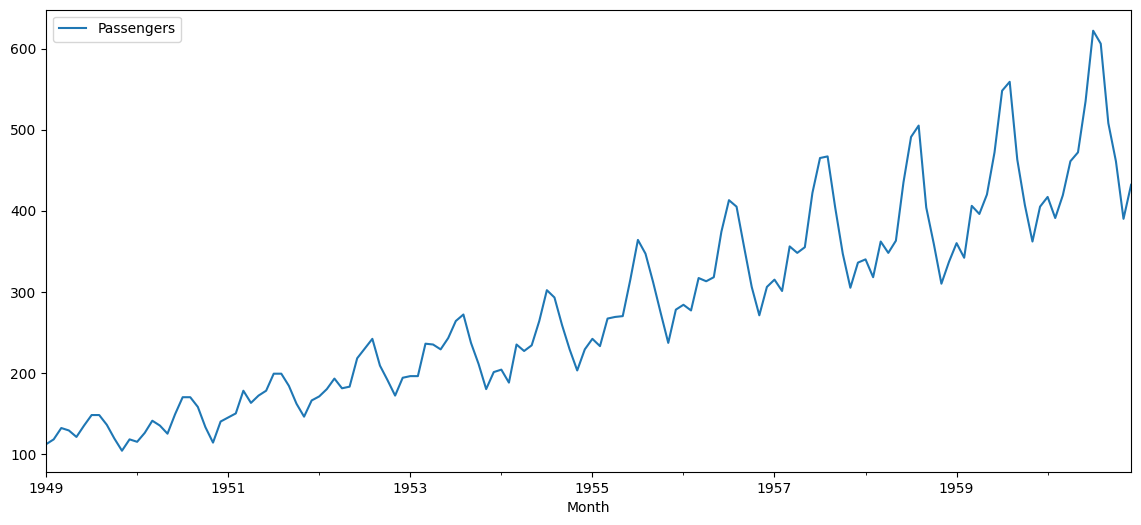

In [11]:

df.plot(figsize=(14,6))
plt.savefig('Data.png')
plt.show

From the graph above clearly can see seasonal pattern, that repeat every year, and uptrend. Let's look at trend and seasonal pattern more closely:

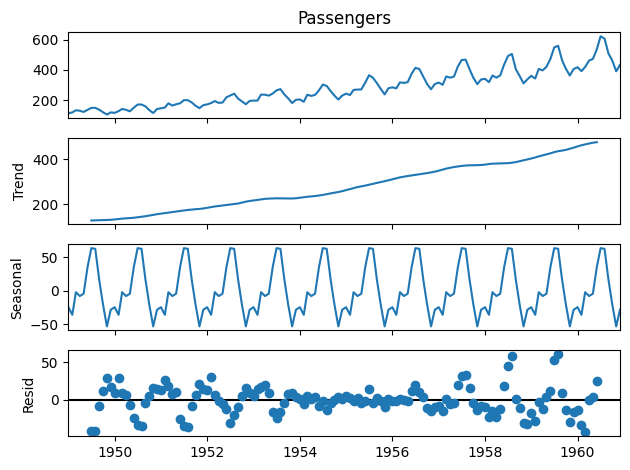

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposed = seasonal_decompose(df['Passengers'])

# Generate the plot
fig = decomposed.plot()

# Save the plot
fig.savefig('decomposed_plot.png')

# Show the plot (optional)
plt.show()

* **Trend**: Time series includes almost linear uptrend, which is good, because linear trend is easier to predict
* **Seasonal**: The same pattern repeats every year: peak values during summer month
* **Resid**: time series after removing trend and seasonality has strong noise. It can cause lower accuracy.

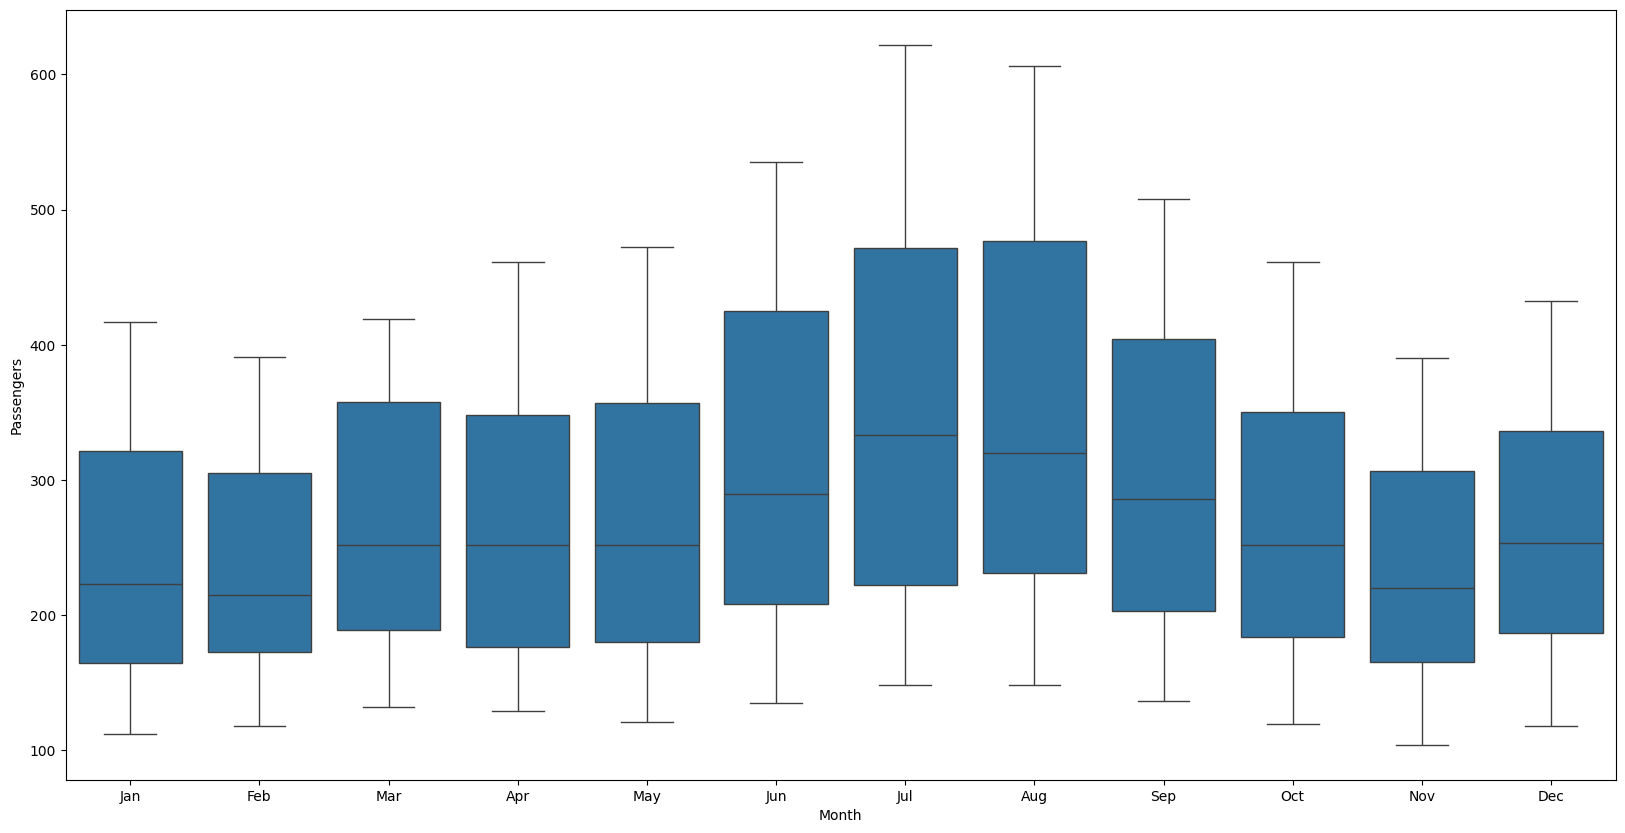

In [14]:
df_month=df.copy()
df_month["Month"]=[d.strftime('%b') for d in df_month.index]

# Create the boxplot
plt.figure(figsize=(20,10))
sns.boxplot(x=df_month["Month"], y=df_month["Passengers"])

# Save the plot
plt.savefig('boxplot_monthly.png')

# Show the plot (optional)
plt.show()

Trend is going up every summer month (people fly on vacation etc) and going down in autumn.

In [15]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(df):
    adf=adfuller(df)
    statistic= adf[0]
    p_value=adf[1]
    critical_values=adf[4]
    return p_value,statistic,critical_values
def stat_check(df,p_value_check=0.05):
    movingAverage = df.rolling(window=12).mean()
    movingSTD = df.rolling(window=12).std()
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    p_value,statistic,critical_values=adfuller_test(df)
    if (p_value<p_value_check):
        print('Time series is stationary, p value:{}'.format(p_value))
    else:
        print('Time series is NOT stationary, p value:{}'.format(p_value))
    print('Statistic:{}'.format(statistic))
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value}')


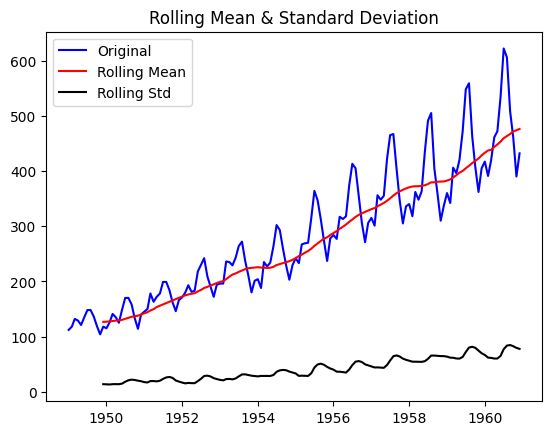

Time series is NOT stationary, p value:0.9918802434376411
Statistic:0.8153688792060528
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

In [17]:

stat_check(df)
plt.savefig('meanandsd.png')
plt.show

# Preprocessing

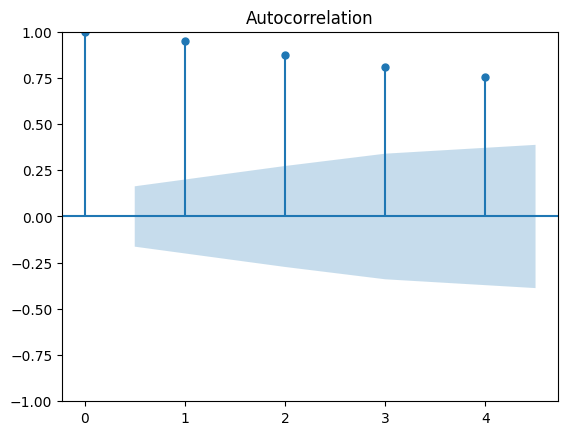

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df,lags=4)
plt.savefig('Autocorrelation.png')
plt.show()

In [20]:
def calculate_mape(actual, predicted):

    if([isinstance(actual, np.ndarray) or isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),  np.array(predicted)
    else:
        actual, predicted = np.Int(actual),  np.Int(predicted)

    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 2)

**Function for selecting parameters for ARIMA**


In [21]:
def arma_select_pq(df):
    arma_order = sm.tsa.arma_order_select_ic(df, ic=['aic', 'bic', 'hqic'], trend='c')
    p = arma_order.aic_min_order[0]
    q = arma_order.aic_min_order[1]
    return p,q


# Naїve forecasting
Estimating technique in which the last period's actuals are used as this period's forecast, without adjusting them or attempting to establish causal factors

In [22]:
naive=df.copy()
split_size=120
train_naive=naive[:split_size]
test=naive[split_size:]
y_naive=test.copy()
#take the last element (119) as future prediction
y_naive["naive forecasting"]= train_naive["Passengers"][split_size-1]


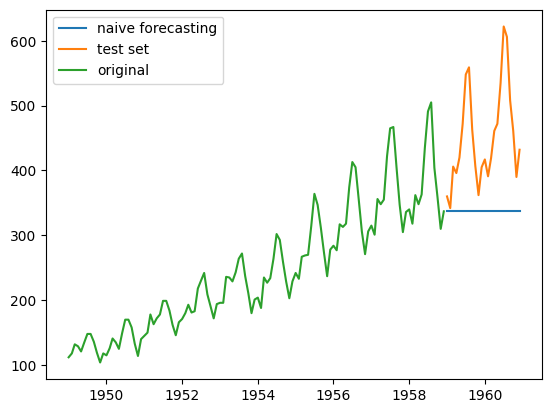

In [24]:
plt.plot(y_naive["naive forecasting"])
plt.plot(y_naive["Passengers"])
plt.plot(train_naive["Passengers"])
plt.savefig('Naiveforec.png')
plt.legend(["naive forecasting","test set","original"])

To make forecasting I need to make TS stationary: remove seasonality and trend. There are plenty of algoritms that can make it, but after ARIMA/SARIMA forecating I need to add trend and seasonality back to the forecasting result.

In [25]:

def deseasonality(df,seasonality):


    column_0=df.columns[0]
    diff = df[column_0].diff(periods=seasonality)
    diff=diff[seasonality:]
    return diff

In [26]:
#Reverse to deasonality: add seasonality to TS
def add_seasonality(df,diff,seasonality):
    column_0=df.columns[0]
    summ=0
    if(type(diff) is pd.core.frame.DataFrame):
        summ = df[column_0].shift(seasonality) + diff[column_0]
        summ=summ[seasonality:]
    else:
        summ = df[column_0].shift(seasonality) + diff
        summ=summ[seasonality:]
    return summ


132


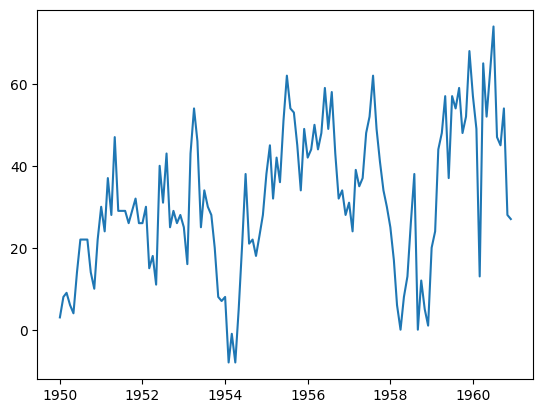

In [27]:
deseasonality_df=deseasonality(df,12)
print(len(deseasonality_df))
plt.plot(deseasonality_df)
plt.show()

132


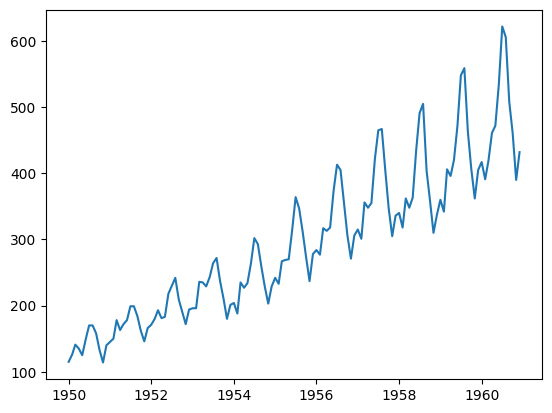

In [28]:
#checking add_seasonality() and add removed seasonality back
de=add_seasonality(df,pd.DataFrame(deseasonality_df),12)
print(len(de))
plt.plot(de)
plt.show()

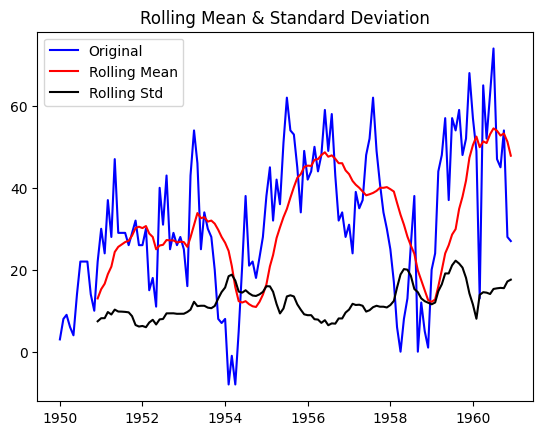

Time series is stationary, p value:0.011551493085514952
Statistic:-3.383020726492481
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


In [29]:
deseasonality_df=pd.DataFrame(deseasonality_df)
stat_check(deseasonality_df)


# Detrending

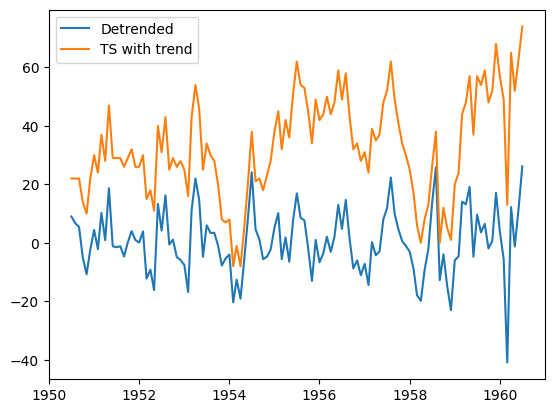

In [30]:
rolling_mean = deseasonality_df.rolling(window=12, center=True).mean()
rolling_mean=rolling_mean.dropna()
detrended = deseasonality_df - rolling_mean
plt.plot(detrended)
detrended_w_trend=detrended+rolling_mean
plt.plot(detrended_w_trend)

plt.legend(["Detrended","TS with trend"])


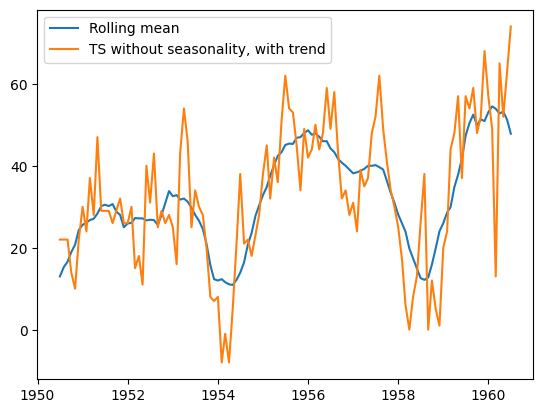

In [31]:
plt.plot(rolling_mean)
detrended_w_trend=detrended+rolling_mean
plt.plot(detrended_w_trend)
plt.legend(["Rolling mean","TS without seasonality, with trend"])

In [32]:
#save detrending and deseasonality ts to dataframe
df_detrended=pd.DataFrame(index=df[18:-5:].index)
df_detrended["Passengers"]=detrended
df_detrended.tail()

,Passengers
Month,
1960-03-01,-40.916667
1960-04-01,12.250000
1960-05-01,-1.250000
1960-06-01,11.750000
1960-07-01,26.166667


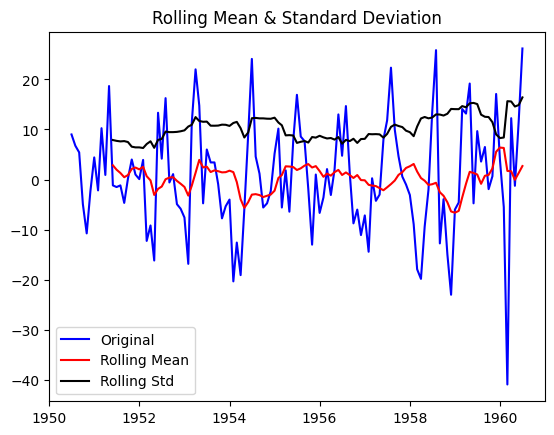

Time series is stationary, p value:1.245664599935459e-09
Statistic:-6.906168409883202
Critial Values:
   1%, -3.487517288664615
Critial Values:
   5%, -2.8865777180380032
Critial Values:
   10%, -2.5801239192052012


In [33]:
stat_check(df_detrended)

# TS Decomposition

**Log scaled**

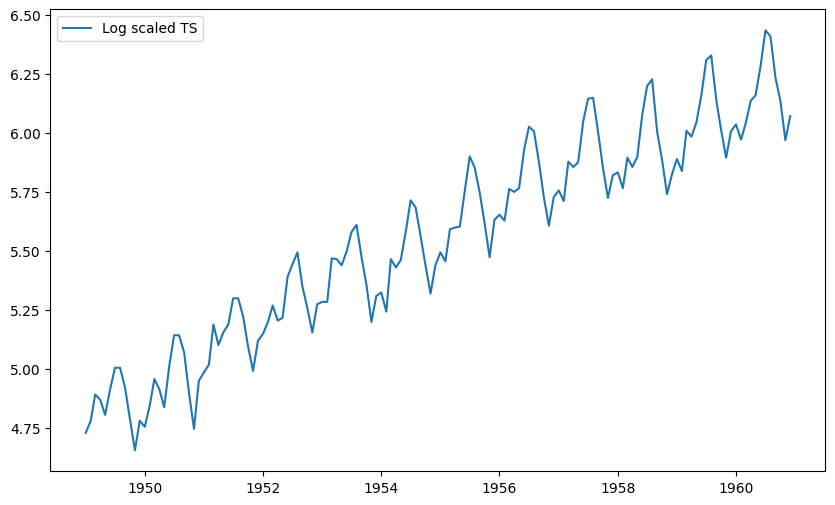

In [36]:
#transform TS into log scale. Log scale TS still is NOT stationary
indexedDataset_logScale = np.log1p(df)
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
#substract mean from log scale TS to make it stationary
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
plt.plot(indexedDataset_logScale)
plt.legend(["Log scaled TS"])


,Passengers
Month,
1960-11-01,-0.182288
1960-12-01,-0.085623


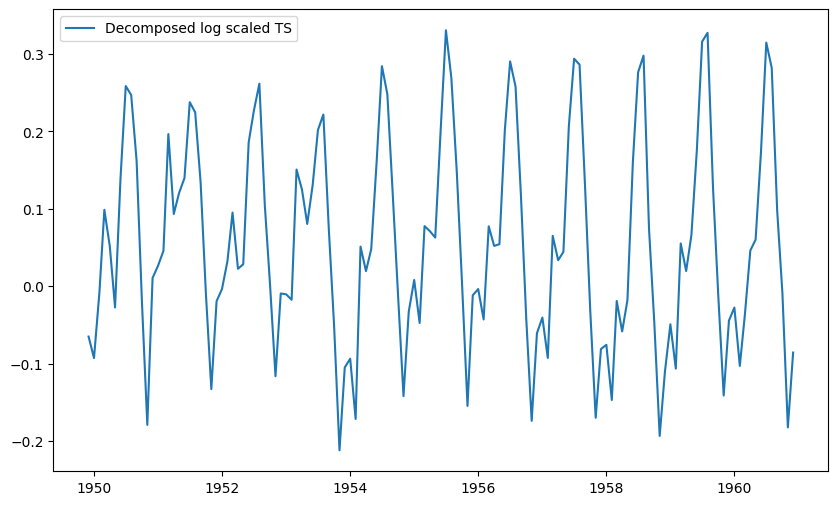

In [37]:
plt.plot(datasetLogScaleMinusMovingAverage)
plt.legend(["Decomposed log scaled TS"])
datasetLogScaleMinusMovingAverage.tail(2)

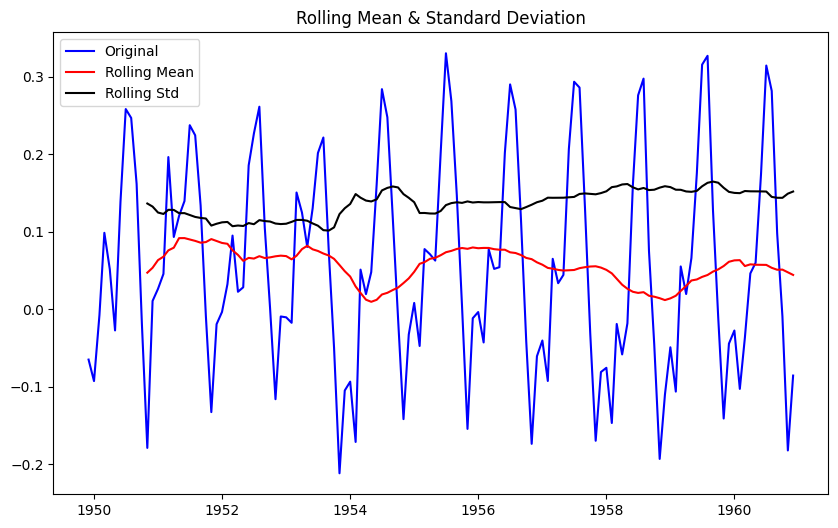

Time series is stationary, p value:0.021896955649248467
Statistic:-3.168260824908217
Critial Values:
   1%, -3.4865346059036564
Critial Values:
   5%, -2.8861509858476264
Critial Values:
   10%, -2.579896092790057


In [38]:
stat_check(datasetLogScaleMinusMovingAverage)

For log scaled TS p = 2, q=4

In [40]:
p,q=arma_select_pq(datasetLogScaleMinusMovingAverage)
print("p:",p,"q:",q)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3 q: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
p,q=arma_select_pq(indexedDataset_logScale)
print("p:",p,"q:",q)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4 q: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Shifting**

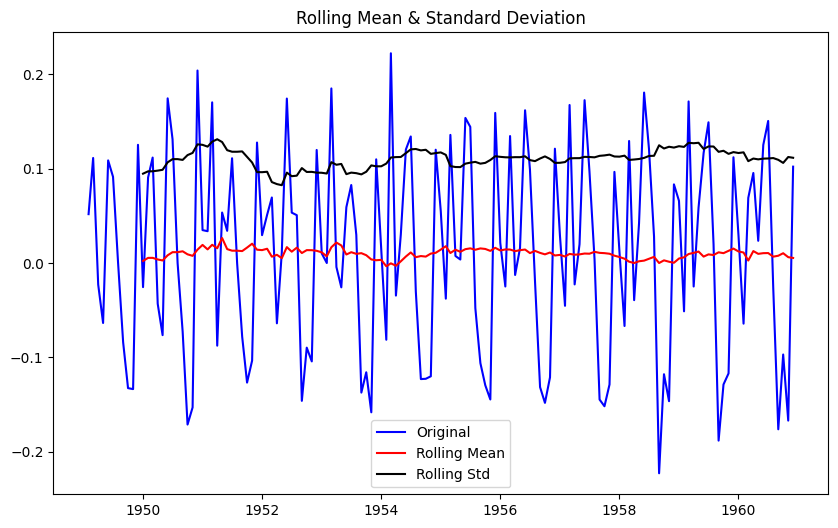

Time series is NOT stationary, p value:0.0703168893633821
Statistic:-2.7219468627062975
Critial Values:
   1%, -3.4825006939887997
Critial Values:
   5%, -2.884397984161377
Critial Values:
   10%, -2.578960197753906


In [42]:
log_shifted=indexedDataset_logScale.shift()#shifting by 1 month
datasetLogDiffShifting = indexedDataset_logScale - log_shifted
datasetLogDiffShifting.dropna(inplace=True)
stat_check(datasetLogDiffShifting)

# **ARIMA Model**

ARIMA consists 3 components:
* Auto Regressive (AR): dependent variable depends on the past values of itself, use PACF to find p
* Integrated (I):prediction on the difference between any two pair of observation rather than directly on the data itself, d (order of differencing)
* Moving Average (MA):specifies the time window for the moving average’s residual error, use ACF to find q

In [43]:
#from statsmodels.tsa.arima.model  import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import statsmodels.api as smapi
def arima_fit(stationary_df,order):
    #frequence https://stackoverflow.com/questions/49547245/valuewarning-no-frequency-information-was-provided-so-inferred-frequency-ms-wi
    stationary_df.index = pd.DatetimeIndex(stationary_df.index.values,
                               freq=stationary_df.index.inferred_freq)
    model = smapi.tsa.arima.ARIMA(stationary_df, order=order)
    results_ARIMA = model.fit()
    plt.plot(stationary_df)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - stationary_df["Passengers"])**2))
    print('Plotting ARIMA model')
    return results_ARIMA


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting ARIMA model


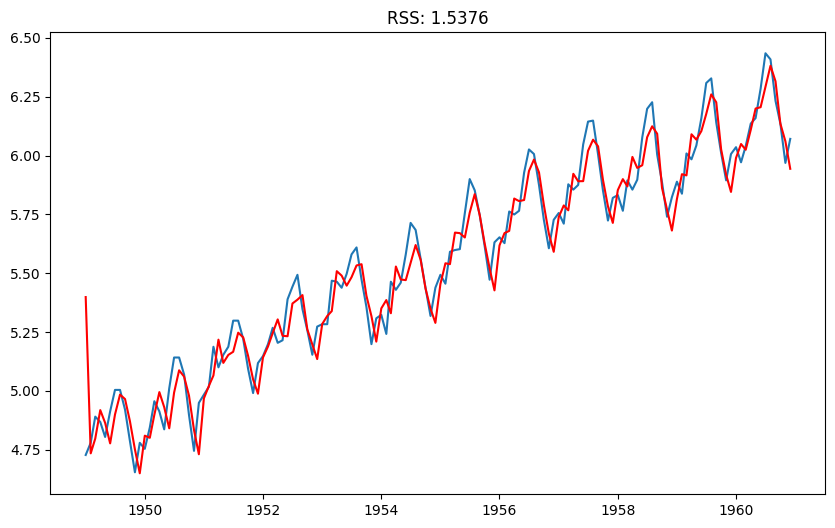

In [44]:
#fit on log scale ts
arima_res_logScale=arima_fit(indexedDataset_logScale,(4,0,3))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting ARIMA model


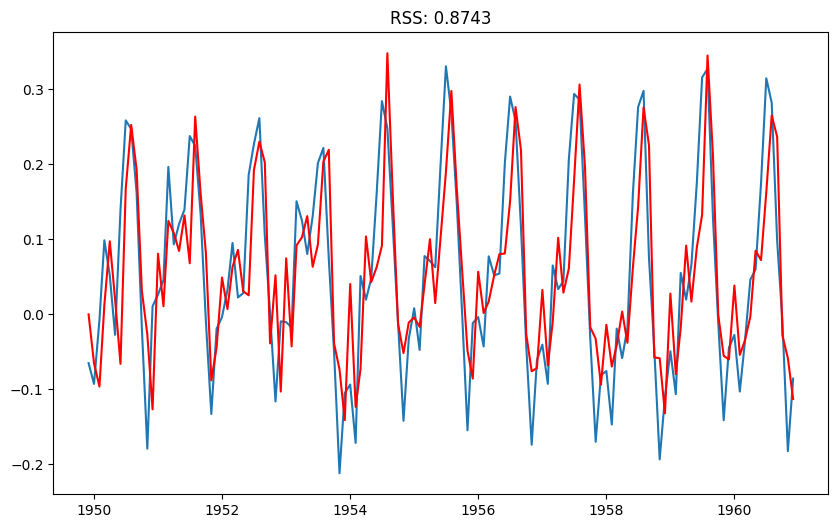

In [45]:
#fit on log scaled - moving average ts
arima_res_logScale_MovAV=arima_fit(datasetLogScaleMinusMovingAverage,(3,1,4))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting ARIMA model


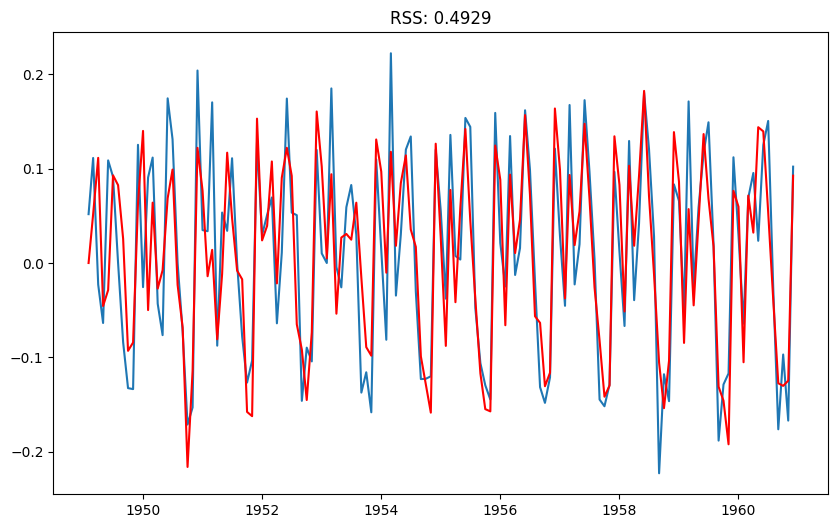

In [46]:
#fit on log scale shifted ts
arima_res_shifrting=arima_fit(datasetLogDiffShifting,(8,1,8))


In [47]:
#find p and q
p,q=arma_select_pq(df_detrended)
print("p:",p,"q:",q)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

p: 4 q: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting ARIMA model


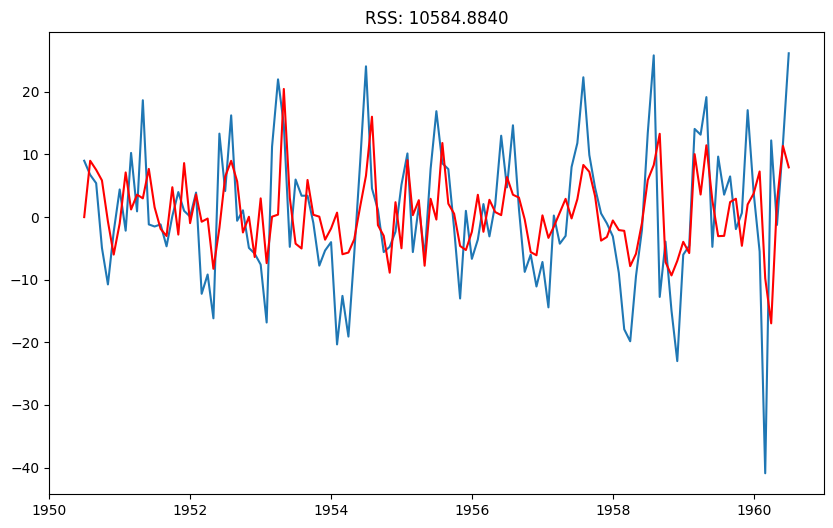

In [48]:
#fit on detrended and deseasonality ts
arima_res_detrended=arima_fit(df_detrended,(4,1,2))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting ARIMA model


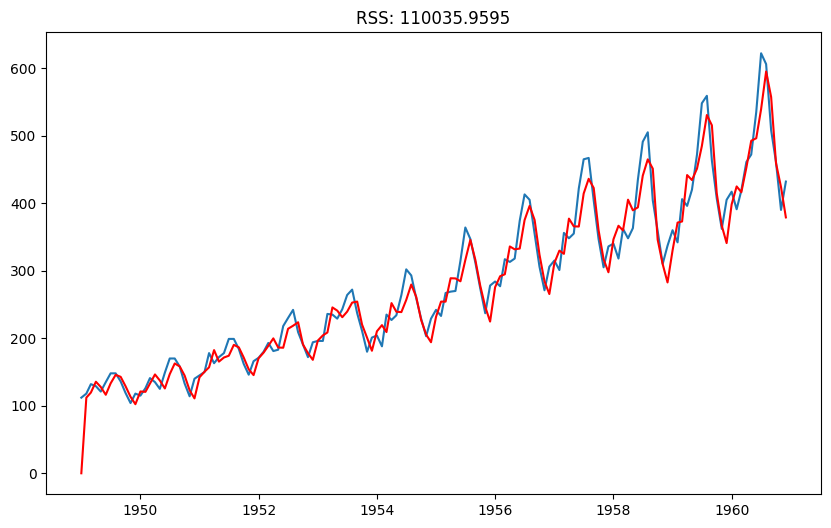

In [49]:
#fit on original ts
arima_res_original=arima_fit(df,(2,1,2))

In [50]:
def forecasting(stationary_df,test_size,order):
    data=stationary_df.copy()
    size = int(len(data) - test_size)
    train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]
    print('\t ARIMA MODEL : In- Sample Forecasting \n')
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = smapi.tsa.arima.ARIMA(history, order=order)
        model_fit = model.fit()

        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(float(yhat))
        obs = test[t]
        history.append(obs)
        print('predicted = %f, expected = %f' % (yhat, obs))
    return predictions

In [51]:
def prediction_plot(predictions,data,test):
    predictions_series = pd.Series(predictions, index = test.index)
    fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

    plt.subplot(1,1,1)
    columns=pd.Series(df.columns)
    plt.plot(data[columns[0]],label = 'Expected Values')
    plt.plot(predictions_series,label = 'Predicted Values');
    plt.legend(loc="upper left")
    plt.show()

**Forecasting for Log stationary**

In [53]:
prediction_log=forecasting(indexedDataset_logScale,24,(4,0,3))

	 ARIMA MODEL : In- Sample Forecasting 



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 5.905668, expected = 5.888878


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 5.915010, expected = 5.837730


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 5.792613, expected = 6.008813


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.070382, expected = 5.983936


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.041924, expected = 6.042633


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.053399, expected = 6.159095


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.132509, expected = 6.308098


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.326263, expected = 6.327937


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.276255, expected = 6.139885


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.026859, expected = 6.011267


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 5.927198, expected = 5.894403


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 5.939559, expected = 6.006353


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.093913, expected = 6.035481


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.070562, expected = 5.971262


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 5.916176, expected = 6.040255


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.085905, expected = 6.135565


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.188318, expected = 6.159095


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.188466, expected = 6.284134


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.271556, expected = 6.434547


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.358969, expected = 6.408529


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.322029, expected = 6.232448


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.137003, expected = 6.135565


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 6.052248, expected = 5.968708
predicted = 5.936515, expected = 6.070738


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


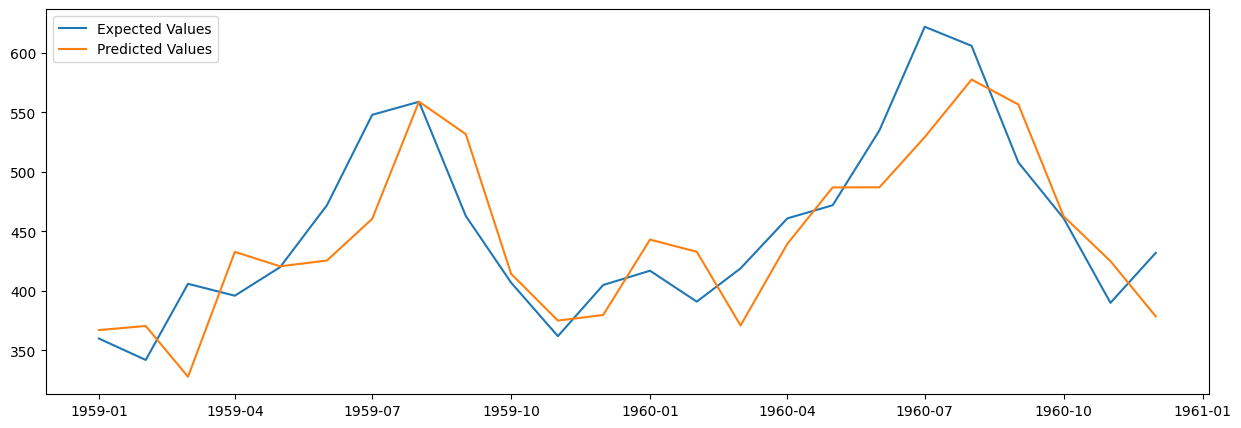

<Figure size 1000x600 with 0 Axes>

In [55]:
# Generate the plot
prediction_plot(np.exp(prediction_log), df[-24:], df[-24:])

# Save the plot
plt.savefig('prediction_plot_arima.png')

# Optionally, display the plot
plt.show()

In [56]:
#using exp to reconstruct log scaled ts to original
print("MSE:",float(tf.keras.metrics.mean_squared_error(df["Passengers"][-24:], np.exp(prediction_log))))
print("MSE:",float(tf.keras.metrics.mean_absolute_error(df["Passengers"][-24:], np.exp(prediction_log))))
print("MAPE (Accuracy):",float(100-calculate_mape(df["Passengers"][-24:], np.exp(prediction_log))))
log_scaled_mape=calculate_mape(df["Passengers"][-24:], np.exp(prediction_log))

MSE: 1970.7250686323393
MSE: 35.836290378804605
MAPE (Accuracy): 92.19


# **SSA Model**

SSA contains 3 parameters: time series YT = (y1, . . . , yT ), the window lenghts L (L ≤ T/2) and K = T − L + 1.

The basic SSA makes the following steps:
* **Computing the trajectory matrix**: this transfers a one-dimensional time series YT = (y1, . . . , yT ) into the multi-dimensional series X1, . . . , XK with vectors Xi =(yi, . . . , yi+L−1), ∈ RL, where K = T − L +1. The single parameter of the embeddingis the window length L, an integer such that 2 ≤ L ≤ T. The result of this step is the trajectory matrix X = [X1, . . . , XK].

* **Constructing a matrix for applying SVD**: compute the matrix XXT

* **SVD of the matrix XXT**: compute the eigenvalues and eigenvectors of the matrix XXT and represent it in the form XXT = PΛPT. Here Λ = diag(λ1, . . . , λL) isthe diagonal matrix of eigenvalues of XXT ordered so that λ1 ≥ λ2 ≥ . . . ≥ λL ≥ 0 and P = (P1, P2, . . . , PL) is the corresponding orthogonal matrix of eigen–vectors of XXT.

* **Selection of eigen–vectors**: select a group of l (1 ≤ l ≤ L) eigen–vectors Pi1, Pi2, . . . , Pil.

* **Reconstruction of the one-dimensional series**: Transition to the one–dimensional series can now be achieved by averaging over the diagonals of the matrix X˜.



In [57]:
#cloning to the working folder
!git clone https://github.com/aj-cloete/pssa
from pssa import mySSA

Cloning into 'pssa'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 110 (delta 6), reused 5 (delta 5), pack-reused 102
Receiving objects: 100% (110/110), 1.03 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [58]:
#check where mySSA.py file is
mySSA

<module 'pssa.mySSA' from '/content/pssa/mySSA.py'>

In [60]:
ts = pd.read_csv('/content/AirPassengers.csv', parse_dates=True, index_col='Month')
#create ssa object, first call file then function
ssa = mySSA.mySSA(ts)
ts.tail(10)

,#Passengers
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


In [61]:
#method check
[x for x in dir(ssa) if '__' not in x and x[0]!='_']

['decompose',
 'diagonal_averaging',
 'embed',
 'forecast_recurrent',
 'freq',
 'get_contributions',
 'ts',
 'ts_N',
 'ts_name',
 'ts_v',
 'view_reconstruction',
 'view_s_contributions',
 'view_time_series']

In [62]:
K = 40 #K = T − L + 1, where L<= L
suspected_seasonality = 12 #seasonality repeats every 12 month
#create trajectory matrix
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  36
Trajectory dimensions	: (36, 109)
Complete dimension	: (36, 109)
Missing dimension     	: (36, 0)


In [63]:
ssa.decompose(verbose=True)
#Dimension of projection space is count of eigenvalues

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 36
Dimension of projection space	: 15
Characteristic of projection	: 0.9998


/content/pssa/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


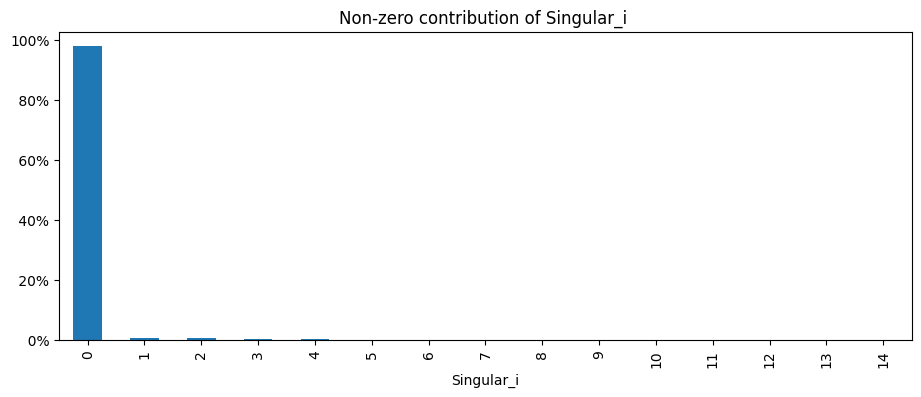

In [64]:
#we can plot contribute of each signals (eaigenvalues)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4
ssa.view_s_contributions()

/content/pssa/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


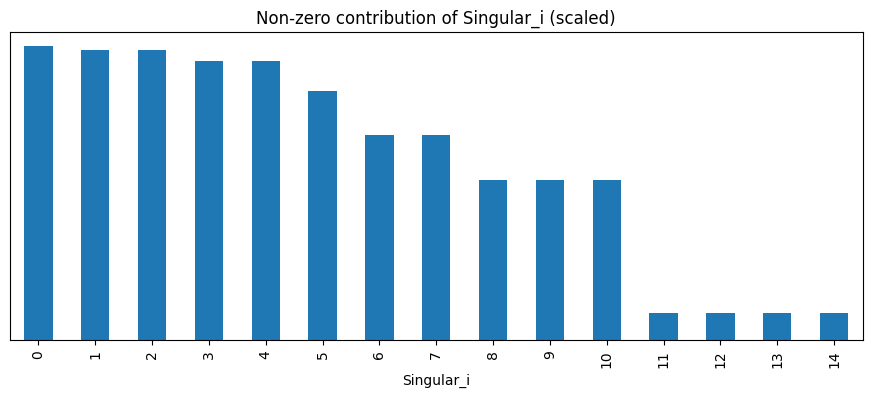

In [65]:
#set adjust_scale for more information
ssa.view_s_contributions(adjust_scale=True)

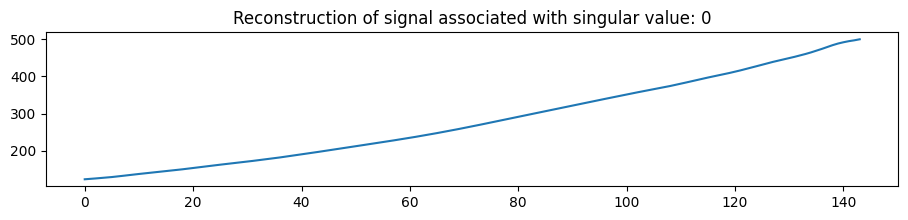

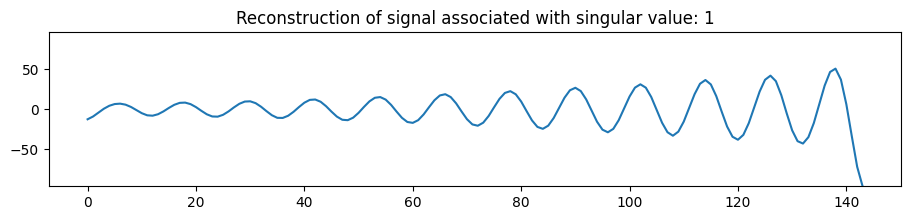

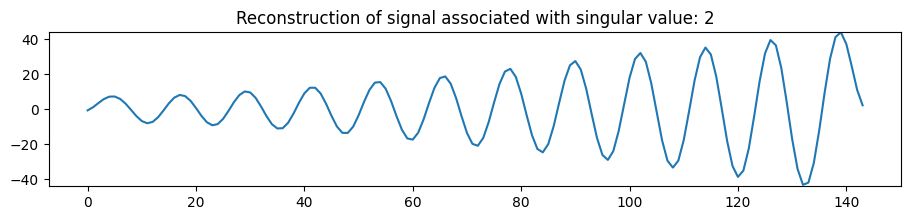

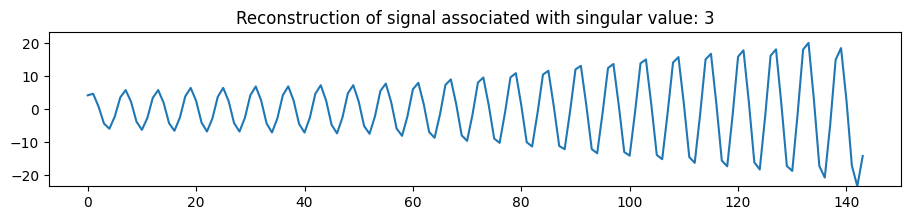

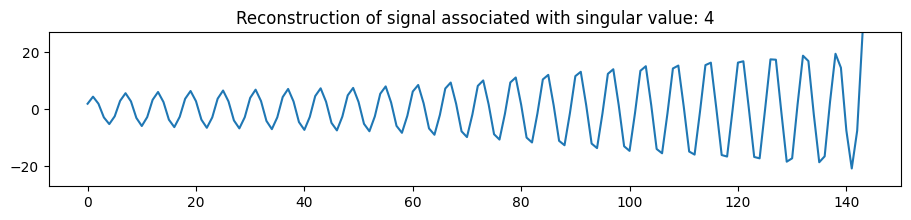

In [66]:
#look at the first 5 signals
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

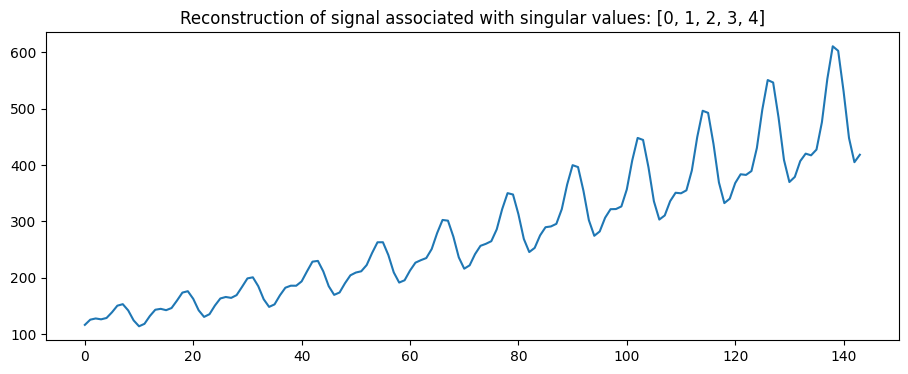

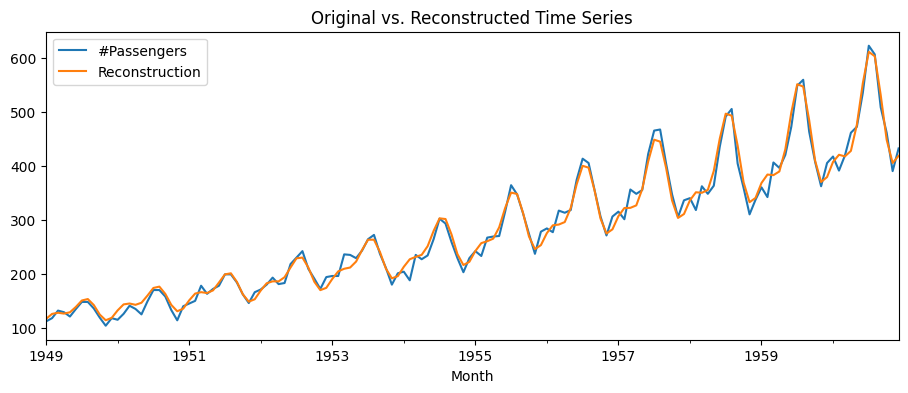

In [67]:
#time series reconstruction with first 5 signals below
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

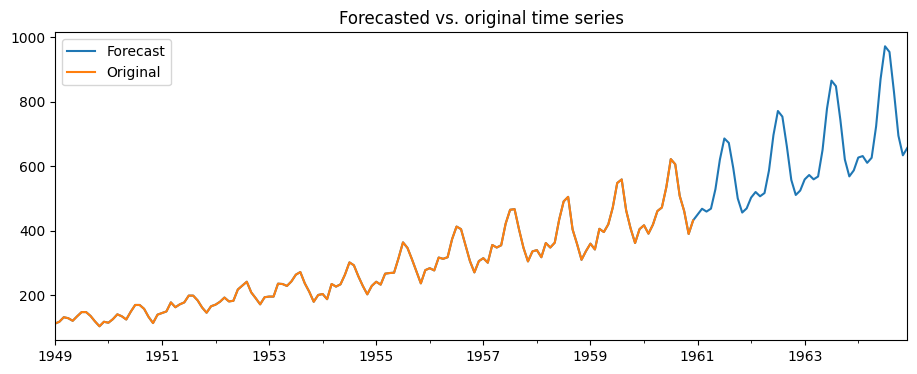

In [70]:
ssa_forecast_5=ssa.forecast_recurrent(steps_ahead=48, singular_values=streams5, plot=True,return_df=True)
plt.savefig('SSA_forecast.png')
plt.show()

In [71]:
#round values
ssa_forecast_5["Forecast"]=[round(value) for value in ssa_forecast_5["Forecast"]]

In [72]:
ssa_forecast_5

,Forecast,Original
1949-01-01,112,112.0
1949-02-01,118,118.0
1949-03-01,132,132.0
1949-04-01,129,129.0
1949-05-01,121,121.0
...,...,...
1964-08-01,954,NaN
1964-09-01,830,NaN
1964-10-01,695,NaN
1964-11-01,634,NaN


In [73]:

print("MSE:",float(tf.keras.metrics.mean_squared_error(ssa_forecast_5["Original"][:144],ssa_forecast_5["Forecast"][:144])))
print("MAE:",float(tf.keras.metrics.mean_absolute_error(ssa_forecast_5["Original"][:144],ssa_forecast_5["Forecast"][:144])))
print("MAPE (Accuracy):",float(100-calculate_mape(ssa_forecast_5["Original"][:144],ssa_forecast_5["Forecast"][:144])))
ssa5_mape=calculate_mape(ssa_forecast_5["Original"][:144],ssa_forecast_5["Forecast"][:144])


MSE: 0.0
MAE: 0.0
MAPE (Accuracy): 100.0


# Exponential Smoothing Model

Exponential smoothing is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.The one which is used

* Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.



In [79]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# prepare data
data = pd.read_csv('/content/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
split=120
train_exp=data[:split]
val_exp=data[split:]

# create class
model_exp_sm = ExponentialSmoothing(train_exp['#Passengers'], seasonal_periods=12,
    trend="add",
    seasonal="add",
    initialization_method="estimated").fit()

# make prediction for 4 years: 2 years for val set and another 2 years for forecasting
y = pd.DataFrame(model_exp_sm.forecast(48), columns=["pred"])


In [80]:
y["Month"]=val_exp["Month"]
y['Month'] = pd.to_datetime(y['Month'], format='%Y-%m')
# create df as forecasting for future
exp_forecasting=pd.DataFrame(y["pred"][24:], columns=["pred"])
#create data range
future = pd.date_range('1961-01-01','1962-12-01', freq='MS')
exp_forecasting['Month']= future
#set date as index for prediction
y.set_index('Month', inplace=True)
#set date as index for forecasting
exp_forecasting.set_index('Month', inplace=True)


In [81]:
train_exp.set_index('Month', inplace=True)
val_exp.set_index('Month', inplace=True)
#model params
model_exp_sm.model.params

{'smoothing_level': 0.23676864752317003,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': 0.7632313524768299,
 'damping_trend': nan,
 'initial_level': 119.19059625959042,
 'initial_trend': 2.2767580286415385,
 'initial_seasons': array([ -9.4861996 ,  -3.87755533,   8.73161242,   3.70764788,
         -4.91512879,   9.27044254,  21.51829455,  19.1904485 ,
          5.06273843, -13.81816029, -28.51984021, -12.35578995]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

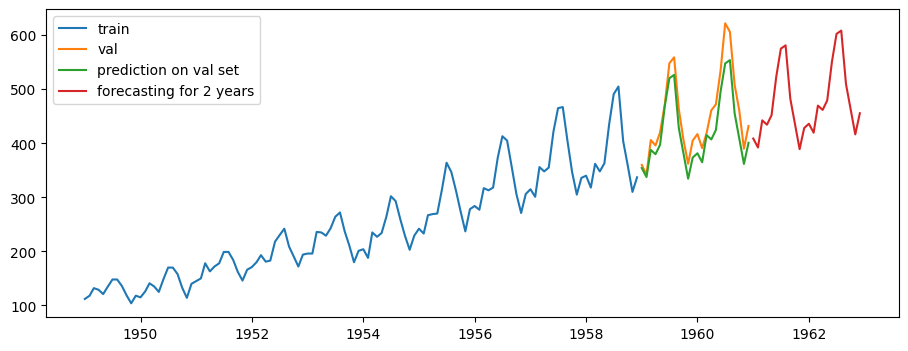

In [83]:

plt.plot(train_exp)
plt.plot(val_exp)
plt.plot(y)
plt.plot(exp_forecasting)

plt.legend(["train","val", "prediction on val set","forecasting for 2 years"])
plt.savefig('expo.png')
plt.show()

In [84]:
import tensorflow as tf
print("MSE:",float(tf.keras.metrics.mean_squared_error(val_exp['#Passengers'], y["pred"][:24])))
print("MAE:",float(tf.keras.metrics.mean_absolute_error(val_exp['#Passengers'], y["pred"][:24])))
print("MAPE (Accuracy):",float(100-calculate_mape(val_exp['#Passengers'], y["pred"][:24])),"%")
exp_smoth_mape=calculate_mape(val_exp['#Passengers'], y["pred"][:24])

MSE: 1278.705499812401
MAE: 31.07637922171719
MAPE (Accuracy): 93.36 %


# **FFT**
Fast Fourier Transform (faster version of the Discrete Fourier Transform, discrete means data measured at discrete interval) is another powerfull method for time series decompositional and forecasting.


In [85]:
import pylab as pl
from numpy import fft
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 25                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [86]:
fft_extrapolation=fourierExtrapolation(np.array(df["Passengers"]), 36)#forecasting for the next 3 years

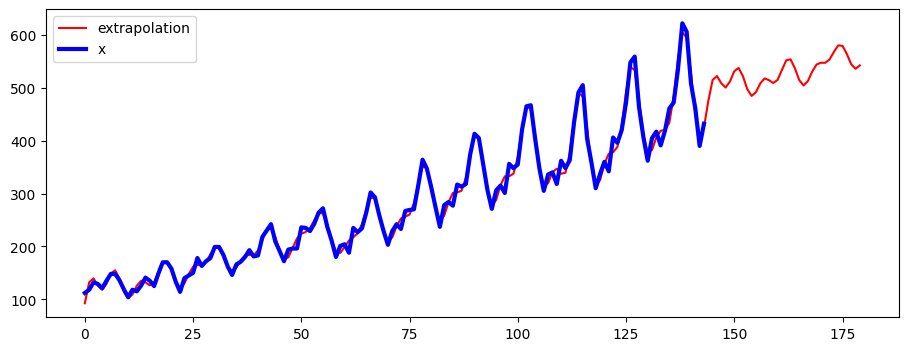

In [88]:
pl.plot(np.arange(0, fft_extrapolation.size), fft_extrapolation, 'r', label = 'extrapolation')
pl.plot(np.arange(0, np.array(df["Passengers"]).size), np.array(df["Passengers"]), 'b', label = 'x', linewidth = 3)
pl.legend()
plt.savefig('FFT.png')
pl.show()

In [89]:
print("MSE:",float(tf.keras.metrics.mean_squared_error(df["Passengers"],fft_extrapolation[:144])))
print("MAE:",float(tf.keras.metrics.mean_absolute_error(df["Passengers"],fft_extrapolation[:144])))
print("MAPE (Accuracy):",float(100-calculate_mape(df["Passengers"],fft_extrapolation[:144])))
fft_mape=calculate_mape(df["Passengers"],fft_extrapolation[:144])

MSE: 142.27498093236306
MAE: 9.174591694078194
MAPE (Accuracy): 96.46


# **Lstm Forecasting**

In [90]:
df=pd.read_csv("/content/AirPassengers.csv")
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)

In [92]:
import datetime
from dateutil.relativedelta import relativedelta
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  first_date =  pd.to_datetime(first_date_str)
  last_date  =  pd.to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Passengers'].to_numpy()
    x, y = values[:-1], values[-1]
#
    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date + relativedelta(months=+1)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))


    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

In [93]:
wd_df=df_to_windowed_df(df, "1949-04-01", "1960-12-01", 3)#has lost 3 month
wd_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1949-04-01,112,118,132,129
1,1949-05-01,118,132,129,121
2,1949-06-01,132,129,121,135
3,1949-07-01,129,121,135,148
4,1949-08-01,121,135,148,148
...,...,...,...,...,...
136,1960-08-01,472,535,622,606
137,1960-09-01,535,622,606,508
138,1960-10-01,622,606,508,461
139,1960-11-01,606,508,461,390


In [94]:
#train/test split
train_df=wd_df[:117]
test_df=wd_df[-24:-12:]#1 year for test data
val_df=wd_df[-12:]#1 year for validation

In [95]:
#data scaling, bool "train" variable indicates the way of transforming
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns=train_df.columns
def scaling(df,train):
    df=df.copy()
    for i in range(1,len(columns)):
        arr=np.asarray(df[columns[i]]).reshape(-1, 1)
        #for train data
        if(train==True):
            arr_norm=scaler.fit_transform(arr)
        #for test/val
        else:
            arr_norm=scaler.transform(arr)
        df[columns[i]]=arr_norm
    return df


In [96]:
train_norm_df=scaling(train_df,True)
test_norm_df=scaling(test_df,False)
val_norm_df=scaling(val_df,False)
val_norm_df

,Target Date,Target-3,Target-2,Target-1,Target
129,1960-01-01,0.755611,0.643392,0.750623,0.780549
130,1960-02-01,0.643392,0.750623,0.780549,0.715711
131,1960-03-01,0.750623,0.780549,0.715711,0.785536
132,1960-04-01,0.780549,0.715711,0.785536,0.890274
133,1960-05-01,0.715711,0.785536,0.890274,0.917706
134,1960-06-01,0.785536,0.890274,0.917706,1.074813
135,1960-07-01,0.890274,0.917706,1.074813,1.291771
136,1960-08-01,0.917706,1.074813,1.291771,1.251870
137,1960-09-01,1.074813,1.291771,1.251870,1.007481
138,1960-10-01,1.291771,1.251870,1.007481,0.890274


In [97]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  Y = df_as_np[:, -1]
  return dates, X.astype(np.float32), Y.astype(np.float32)

In [98]:
#split on dates, x and y
dates_train, X_train, y_train = windowed_df_to_date_X_y(train_norm_df)
dates_test, X_test, y_test = windowed_df_to_date_X_y(test_norm_df)
dates_val, X_val, y_val = windowed_df_to_date_X_y(val_norm_df)

X_train shape: (117, 3, 1) Y_train shape: (117,) X_test shape: (12, 3, 1) Y_test shape: (12,) X_val shape: (12, 3, 1) Y_val shape: (12,)


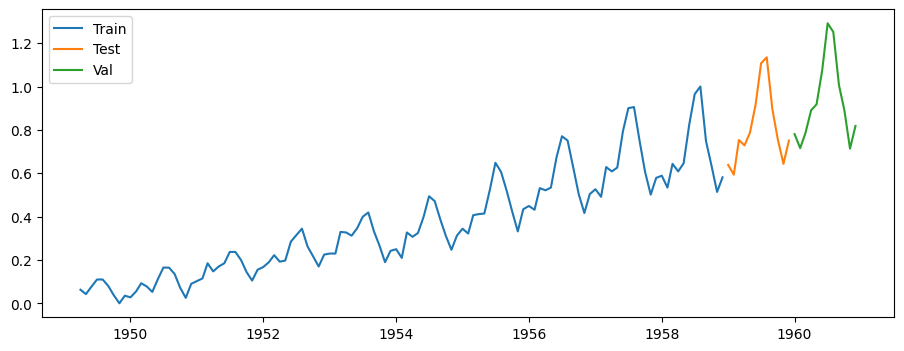

In [99]:
plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)
plt.plot(dates_val, y_val)

plt.legend(['Train', 'Test', 'Val'])
print("X_train shape:",X_train.shape,"Y_train shape:",y_train.shape,"X_test shape:",X_test.shape,"Y_test shape:",y_test.shape,"X_val shape:",X_val.shape,"Y_val shape:",y_val.shape)

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

In [112]:
# Reshape data for LSTM input
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create the model
lstm_model = create_lstm_model(input_shape=(X_train_lstm.shape[1], 1))

# Fit the model
history = lstm_model.fit(X_train_lstm, y_train, epochs=100, validation_data=(X_test_lstm, y_test), batch_size=8, verbose=1)

Epoch 1/100
15/15 [==============================] - 7s 48ms/step - loss: 0.1682 - val_loss: 0.5772
Epoch 2/100
15/15 [==============================] - 0s 19ms/step - loss: 0.1126 - val_loss: 0.3355
Epoch 3/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0445 - val_loss: 0.0528
Epoch 4/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0317 - val_loss: 0.0998
Epoch 5/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0235 - val_loss: 0.0526
Epoch 6/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0203 - val_loss: 0.0601
Epoch 7/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0182 - val_loss: 0.0638
Epoch 8/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0180 - val_loss: 0.0624
Epoch 9/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0178 - val_loss: 0.0595
Epoch 10/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0166 - val_loss: 0.0634

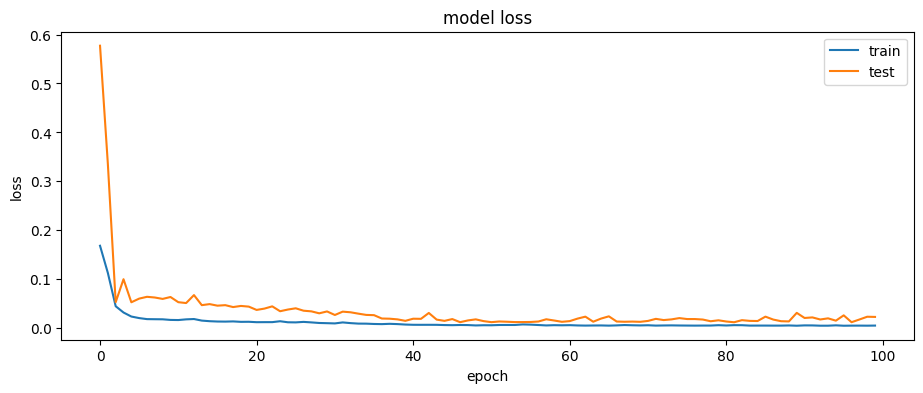

In [117]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig('lstm_loss.png')
    plt.show()

plot_history(history)

In [115]:
# Calculate metrics
prediction_df = pd.DataFrame({"Prediction": np.asarray(scaler.inverse_transform(lstm_predictions.reshape(-1, 1))).reshape(12), "True value": np.array(df["Passengers"][-12:])}, index=dates_val)
prediction_df["Prediction"] = [round(value) for value in prediction_df["Prediction"]]
print("MSE:", float(tf.keras.metrics.mean_squared_error(prediction_df["True value"], prediction_df["Prediction"])))
print("MAE:", float(tf.keras.metrics.mean_absolute_error(prediction_df["True value"], prediction_df["Prediction"])))
print("MAPE (Accuracy):", 100 - calculate_mape(np.array(prediction_df["True value"]), np.array(prediction_df["Prediction"])))

MSE: 6082.0
MAE: 64.0
MAPE (Accuracy): 86.57


# **Prophet Model**

In [118]:
df_prophet=pd.DataFrame()
df_prophet['ds'] = month
df_prophet["y"]=df["Passengers"].to_numpy()
df_prophet

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [119]:
train_set=df_prophet[:132]
val_set=df_prophet[-12:]#1 year for val set

In [120]:

from prophet import Prophet
prophet = Prophet()
prophet=prophet.fit(train_set)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpppnqhmk8/bzpbmi91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpppnqhmk8/cu6elq4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91971', 'data', 'file=/tmp/tmpppnqhmk8/bzpbmi91.json', 'init=/tmp/tmpppnqhmk8/cu6elq4w.json', 'output', 'file=/tmp/tmpppnqhmk8/prophet_modelwmuqlnxd/prophet_model-20240604062119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [121]:

prediction = prophet.predict(val_set)
prediction.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-01-01,447.190892,399.564661,449.607188,447.190892,447.191549,-22.309449,-22.309449,-22.309449,-22.309449,-22.309449,-22.309449,0.0,0.0,0.0,424.881443
1,1960-02-01,450.209313,395.746638,444.507423,450.197454,450.229165,-28.719627,-28.719627,-28.719627,-28.719627,-28.719627,-28.719627,0.0,0.0,0.0,421.489685


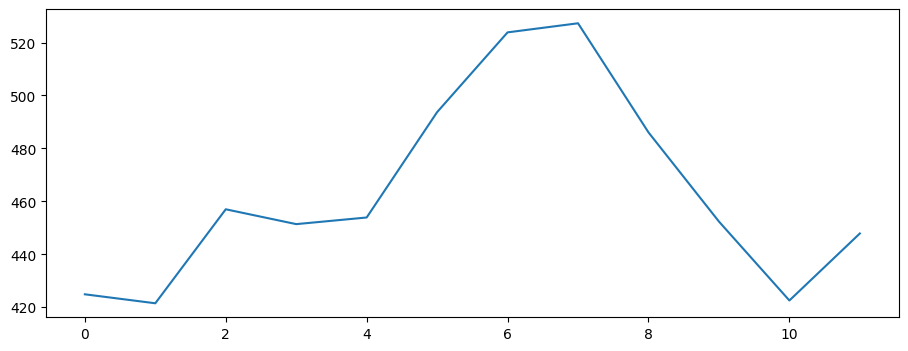

In [124]:

plt.plot(prediction["yhat"])
plt.savefig('prophet.png')
pl.show()

In [123]:

print("MSE:",float(tf.keras.metrics.mean_squared_error(df_prophet["y"][-12:], prediction["yhat"])))
print("MAE:",float(tf.keras.metrics.mean_absolute_error(df_prophet["y"][-12:], prediction["yhat"])))
print("MAPE (Accuracy):",100- calculate_mape(np.array(df_prophet["y"][-12:]),np.array(prediction["yhat"])))
prophet_mape=calculate_mape(np.array(df_prophet["y"][-12:]),np.array(prediction["yhat"]))

MSE: 1854.835348479608
MAE: 33.43448456958556
MAPE (Accuracy): 93.39


# Conclusion

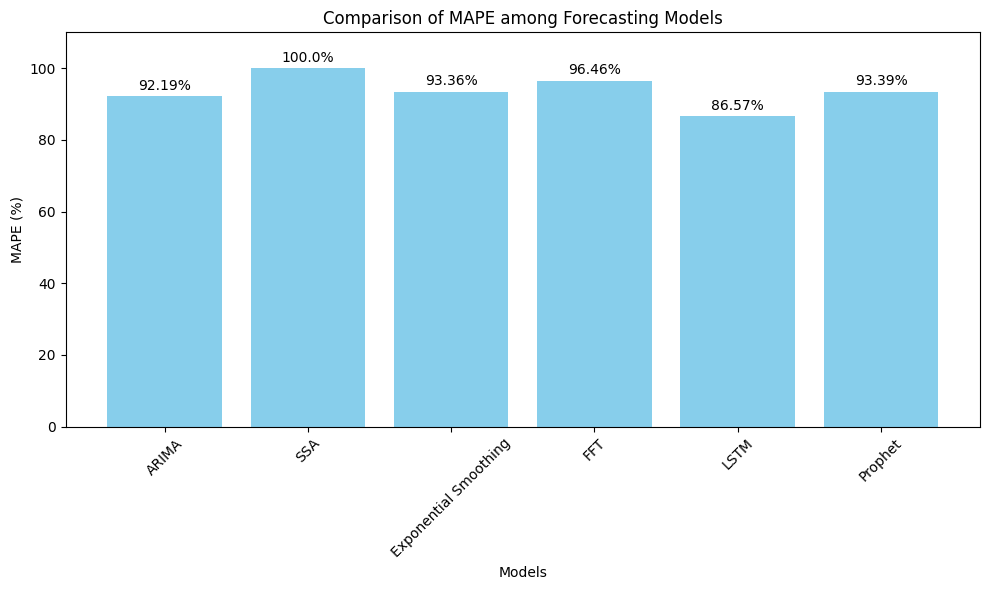

In [127]:
import matplotlib.pyplot as plt

# MAPE values for different models
models = ['ARIMA', 'SSA', 'Exponential Smoothing', 'FFT', 'LSTM', 'Prophet']
mapes = [92.19, 100.0, 93.36, 96.46, 86.57, 93.39]  # Filling in the MAPE values for each model

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mapes, color='skyblue')
plt.title('Comparison of MAPE among Forecasting Models')
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.ylim(0, 110)  # Setting y-axis limit
plt.xticks(rotation=45)

# Adding the numerical values on top of each bar
for bar, mape in zip(bars, mapes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{mape}%', ha='center', va='bottom')

plt.tight_layout()

# Save the plot
plt.savefig('mape_comparison_with_values.png')

# Show the plot
plt.show()
